# Heart Disease Prediction

## Introduction
We will be using the Heart Disease data folder. Specifically, we are using the Processed Hungarian Data, which is a data set in the Heart Disease folder. Our data was collected by the Hungarian Institute of Cardiology in Budapest on Heart Disease patients. Although there are 76 characteristics in this database, all published studies only mention utilizing a subset of 14. The Cleveland database in particular is the only one that ML researchers have utilized up until this point. For this reason, we are using a different dataset (hungarian) as we expect to uncover new analyses based on this data as it hasn’t already been utilized by other researchers.

Heart disease can refer to several types of heart conditions, the most common being the buildup of plaque in the major blood vessels leading to the heart. Cholesterol deposits in the arteries reduce blood flow to the heart. A reduced blood flow to the heart often results in a heart attack.
Our project aims to determine if someone has heart disease, based on some of the selected predictors in the dataset. This aim is guided by the following predictive question, “Which health indicators strongly correlate with heart disease?”

## Methods and Results
In the code below, we read the data from the url, clean and wrangle it, split it into training and testing sets, compute summary statistics on the training data, standardize the training data. We also plot multiple sets of 2 of the standardized predictors (e.g. age and max heart rate) onto a scatter plot and colour the points based on whether the individual has heart disease to discuss and justify why we chose the predictors that we did for our analysis. Then we perform knn classification by first running cross validation to find a number of neighbours for which our accuracy estimate is high and then use our model to predict on our testing data, determine the testing accuracy, and plot a confusion matrix. Our process and code are justified and explained further below and in the discussion as well.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We will start by setting the seed and reading the data from the url. We will also add some column names since the dataset itself does not include them.

In [2]:
# Set seed
set.seed(1000)

# Read data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart_disease_data <- read_csv(url, col_names = FALSE)

# Add column names
heart_disease_data <- rename(heart_disease_data,
       age = X1, 
       sex = X2, 
       chest_pain_type = X3,
       resting_blood_pressure = X4, 
       cholestorol = X5, 
       fasting_blood_sugar = X6,
       restecg = X7, 
       max_heart_rate = X8, 
       exercise_induced_angina = X9,
       ST_depression = X10, 
       slope = X11, 
       ca = X12,
       thal = X13, 
       has_heart_disease = X14)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, we remove columns from the data that will not be used in our analysis and filter out observations that have missing data (data with '?' character). We removed the slope, ca, and thal columns from our dataframe because for these columns most of the data is missing. For the remaining columns, for which the missing data is sparse, we removed observations with missing data because our classifier would not work correctly if some observations had missing data for the predictors. Since this missing data is present only sparsely and our dataset is quite large, removing the observations with missing data will not affect our model very much. The resulting data frame is shown in Table 1 below.

In [3]:
# Remove unnecessary columns (these won't be used in our analysis)
heart_disease_data <- heart_disease_data |>
   select(-slope, -ca, -thal)

# Filter out observations with missing data
heart_disease_data <- heart_disease_data |>
   filter(resting_blood_pressure != '?', cholestorol != '?', fasting_blood_sugar != '?', restecg != '?', max_heart_rate != '?', exercise_induced_angina != '?', ST_depression != '?')
heart_disease_data

age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


Table 1: Heart Disease Data Frame After Removing Unncessary Columns and Observations with Missing Data

Now we convert the columns in our data to numeric type so that they are easier to analyze and work with. We also convert the heart disease labels from numbers (1 and 0) to words (Yes and No) for easier interprebility when reading the data.

In [4]:
# Convert columns to numeric type
heart_disease_data$resting_blood_pressure <- as.numeric(heart_disease_data$resting_blood_pressure)
heart_disease_data$cholestorol <- as.numeric(heart_disease_data$cholestorol)
heart_disease_data$fasting_blood_sugar <- as.numeric(heart_disease_data$fasting_blood_sugar)
heart_disease_data$restecg <- as.numeric(heart_disease_data$restecg)
heart_disease_data$max_heart_rate <- as.numeric(heart_disease_data$max_heart_rate)
heart_disease_data$exercise_induced_angina <- as.numeric(heart_disease_data$exercise_induced_angina)
heart_disease_data$ST_depression <- as.numeric(heart_disease_data$ST_depression)
heart_disease_data$has_heart_disease <- as.factor(heart_disease_data$has_heart_disease)

# Convert heart disease labels from numbers to words
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '0'] <- 'No'
levels(heart_disease_data$has_heart_disease)[levels(heart_disease_data$has_heart_disease) == '1'] <- 'Yes'

Now, we begin our analysis by splitting the data into training and testing sets. We chose a 75% to 25% split of training to testing sets. The training set we will use is shown in Table 2 below.

In [5]:
# Split the data into training and testing sets
heart_disease_data_split <- initial_split(heart_disease_data, prop = 0.75, strata = has_heart_disease)
heart_disease_data_training <- training(heart_disease_data_split)
heart_disease_data_testing <- testing(heart_disease_data_split)

# Print training data
heart_disease_data_training

age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,No
30,0,1,170,237,0,1,170,0,0,No
32,0,2,105,198,0,0,165,0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
54,0,3,130,294,0,1,100,1,0,Yes
56,1,4,155,342,1,0,150,1,3,Yes
65,1,4,130,275,0,1,115,1,1,Yes


Table 2: Heart Disease Training Data

Next, we compute some summary statistics on our data. The summary statistics (shown in Table 3 below) were computed by grouping the rows based on whether the individual has heart disease and then computing the means of the relevant predictors. We don't include the sex, chest pain type, resting electrocardiographic results, and exercise induced angina columns since these columns are discrete where each discrete value maps to a distinct result so a mean would not provide any helpful information.

In [6]:
# Summarize the training data by grouping by num and calculating means of the various columns
summary <- heart_disease_data_training |>
   group_by(has_heart_disease) |>
   summarize(across(age:ST_depression, mean))

# Remove columns for which mean is not useful (i.e. data is discrete and not continuous)
summary <- summary |>
   select(-sex, -chest_pain_type, -restecg, -exercise_induced_angina)

# Print summary statistics
summary

has_heart_disease,age,resting_blood_pressure,cholestorol,fasting_blood_sugar,max_heart_rate,ST_depression
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,46.94262,131.6148,240.2705,0.04098361,147.5492,0.2172131
Yes,49.49315,135.2877,265.8356,0.13698630,128.5068,1.2876712


Table 3: Heart Disease Data Summary Statistics

These summary statistics show useful information about our dataset. We see that the average age, resting blood pressure, cholestorol, fasting blood sugar, maximum heart rate, and ST depression induced by exercise for individuals with heart disease is higher than individuals without heart disease.

We scale the data so that we can perform knn classification on it.

In [7]:
# Select data to visualize
heart_disease_training_plot_data <- heart_disease_data_training

# Scale data for effective visualization
heart_disease_recipe <- recipe(has_heart_disease ~ ., data = heart_disease_training_plot_data) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

Now we perform 5-fold cross validation to find a suitable value of k for our knn classification. We plot our accuracy versus k, as shown in Figure 1 below, to see that value of k for which we have the highest training accuracy.

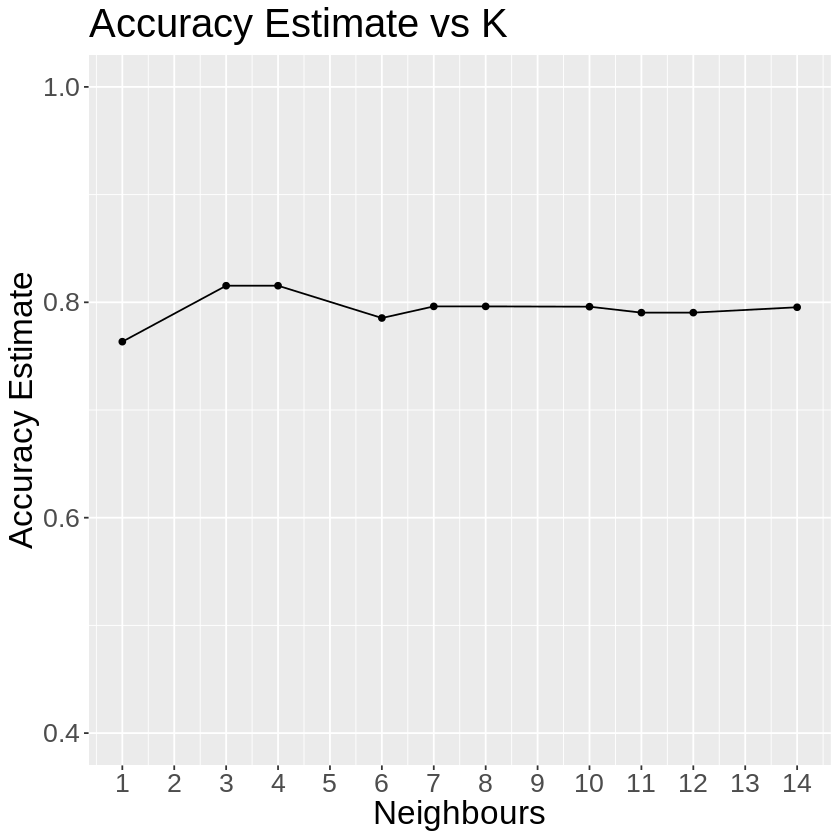

In [8]:
# Cross Validation
heart_vfold <- vfold_cv(heart_disease_training_plot_data, v = 5, strata = has_heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = heart_vfold, grid = 10) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      xlab("Neighbours") +
      ylab("Accuracy Estimate") +
      ggtitle("Accuracy Estimate vs K") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0)) +
      theme(text = element_text(size = 20))
accuracy_versus_k

Figure 1: Accuracy Estimate vs K

We see from the plot that the K value with the highest training accuracy is k = 3 so we select this as our value. We create our model specification with k = 3 and combine it with our recipe from before into a workflow and build our classifier.

In [9]:
# Set seed
set.seed(1000)

knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(heart_disease_recipe) |>
      add_model(knn_model) |>
      fit(data = heart_disease_training_plot_data)

Now, we test our classifier by making predictions for the data in our testing set. The data with predictions is shown in Table 4 below.

In [10]:
# Set seed
set.seed(1000)

heart_test_predictions <- predict(heart_fit , heart_disease_data_testing) |>
      bind_cols(heart_disease_data_testing)
heart_test_predictions

.pred_class,age,sex,chest_pain_type,resting_blood_pressure,cholestorol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,ST_depression,has_heart_disease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
No,29,1,2,120,243,0,0,160,0,0,No
No,31,0,2,100,219,0,1,150,0,0,No
No,32,1,2,110,225,0,0,184,0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yes,47,1,4,160,291,0,1,158,1,3,Yes
Yes,52,1,4,140,266,0,0,134,1,2,Yes
Yes,58,0,2,180,393,0,0,110,1,1,Yes


Table 4: Heart Disease Data with Predictions

The prediction accuracy, as shown in Table 5 below, is about 81.8% which is relatively good.

In [11]:
heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = has_heart_disease, estimate = .pred_class)
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8181818
kap,binary,0.6195965


Table 5: Heart Disease Prediction Metrics from Test Data

We have included 3 visualizations (as shown in Figures 2, 3, and 4 below) for exploratory data analysis relating to our analysis. They are scatter plots with 2 predictors (one on each axis) and coloured by heart disease. These plots are discussed in further detail in our discussion.

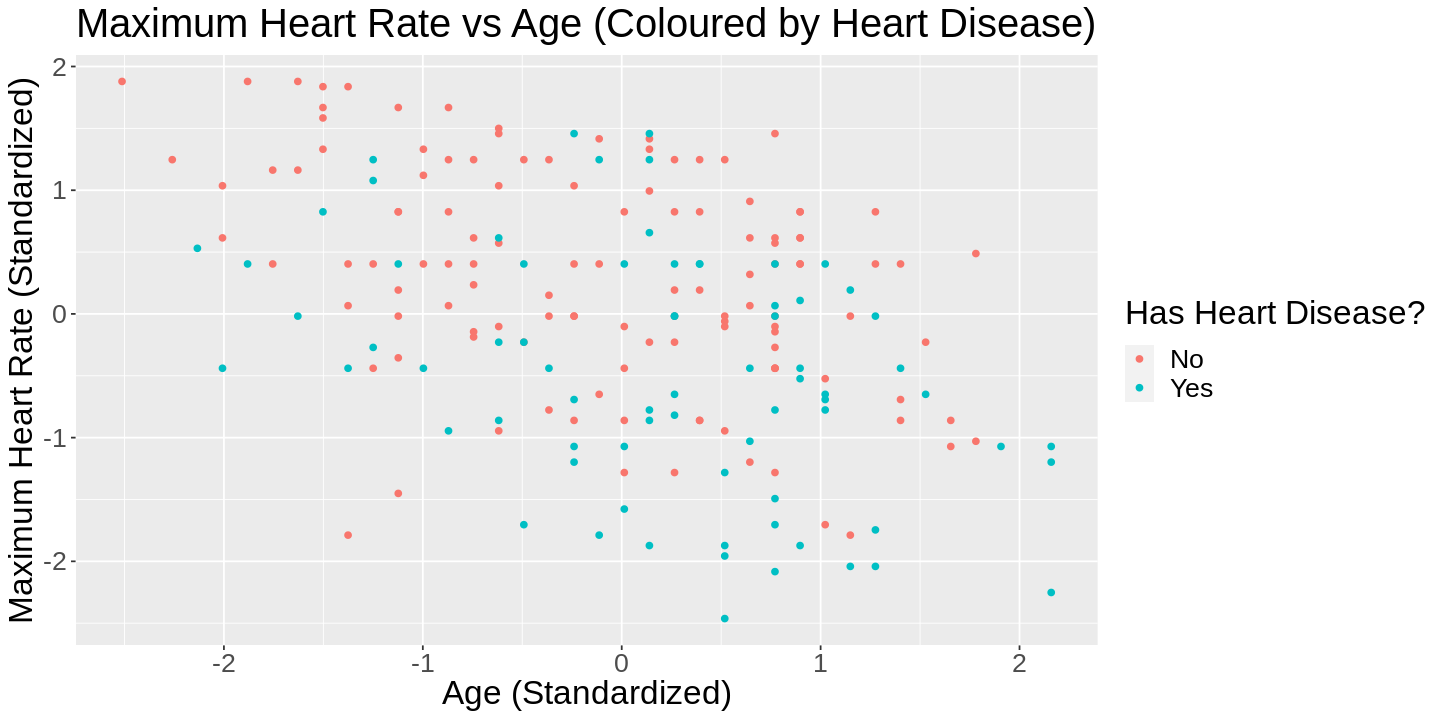

In [12]:
# Set seed
set.seed(1000)

heart_disease_recipe <- heart_disease_recipe |>
   prep()
scaled_heart_disease_data <- bake(heart_disease_recipe, heart_disease_training_plot_data)

# Change plot dimensions
options(repr.plot.width = 12, repr.plot.height = 6)

# Plot data
heart_disease_plot_1 <- scaled_heart_disease_data |>
   ggplot(aes(x = age, y = max_heart_rate, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Age (Standardized)", y = "Maximum Heart Rate (Standardized)", title = "Maximum Heart Rate vs Age (Coloured by Heart Disease)", color = "Has Heart Disease?")

heart_disease_plot_2 <- scaled_heart_disease_data |>
   ggplot(aes(x = age, y = cholestorol, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Age (Standardized)", y = "Cholestorol (Standardized)", title = "Cholestorol vs Age (Coloured by Heart Disease)", color = "Has Heart Disease?")

heart_disease_plot_3 <- scaled_heart_disease_data |>
   ggplot(aes(x = resting_blood_pressure, y = max_heart_rate, color = has_heart_disease)) +
   geom_point() +
   theme(text = element_text(size = 20)) +
   labs(x = "Resting Blood Pressure (Standardized)", y = "Maximum Heart Rate (Standardized)", title = "Maximum Heart Rate vs Resting Blood Pressure (Coloured by Heart Disease)", color = "Has Heart Disease?")

# Display plot
heart_disease_plot_1

Figure 2: Maximum Heart Rate vs Age (Coloured by Heart Disease)

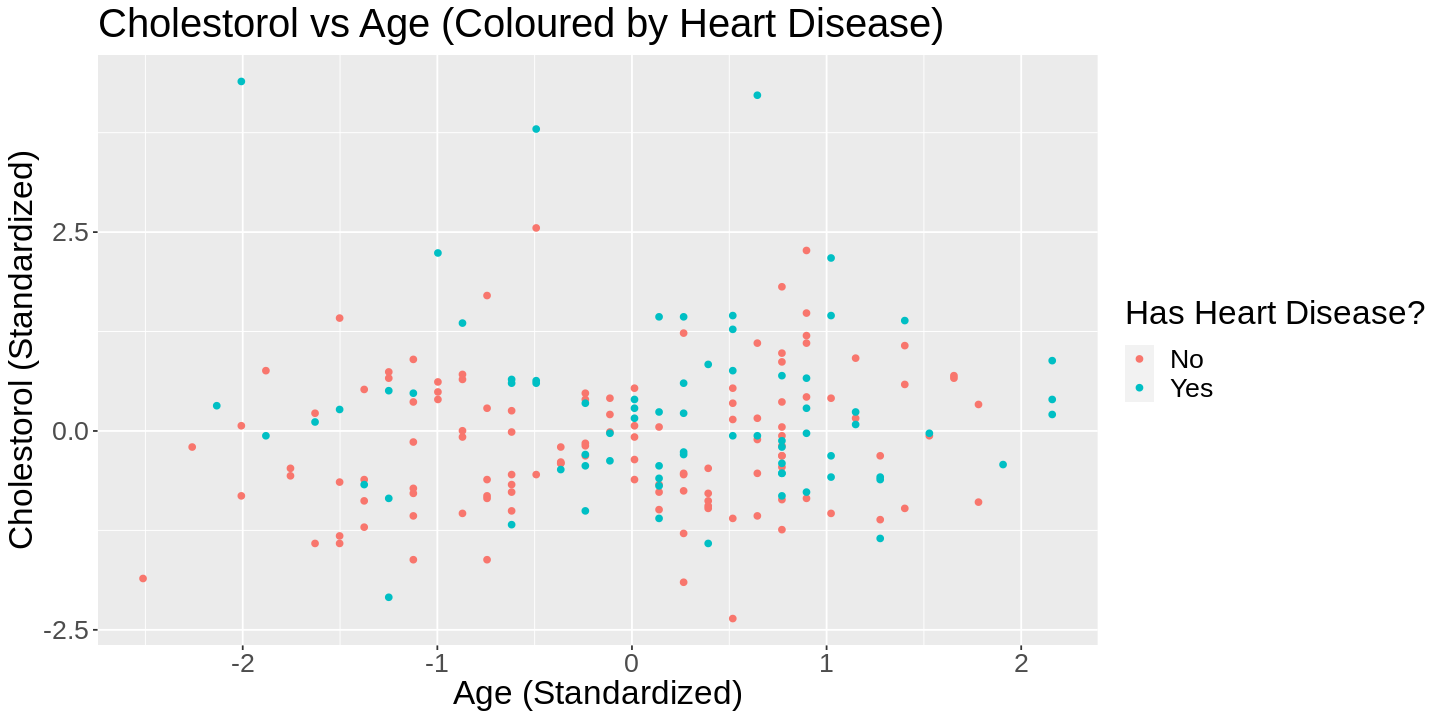

In [13]:
# Display Plot
heart_disease_plot_2

Figure 3: Cholestorol vs Age (Coloured by Heart Disease)

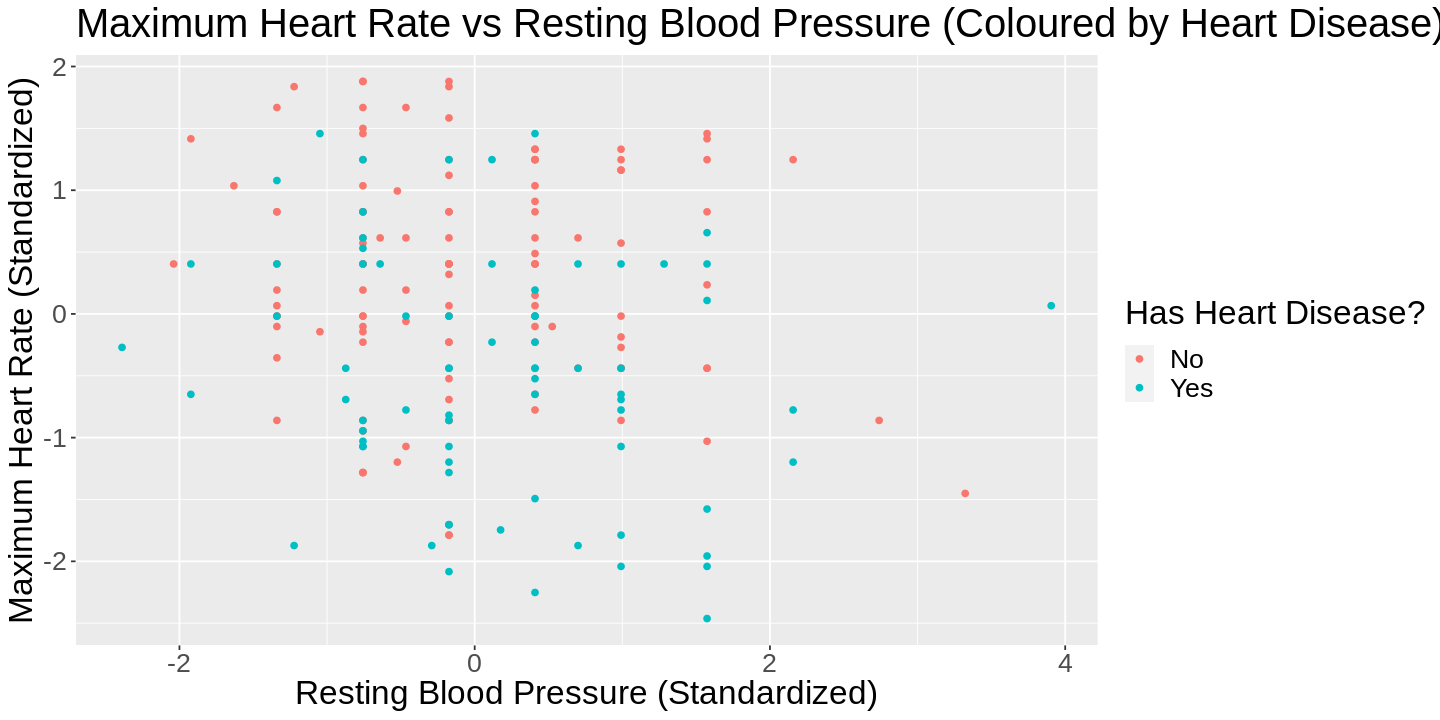

In [14]:
# Display Plot
heart_disease_plot_3

Figure 4: Maximum Heart Rate vs Resting Blood Pressure (Coloured by Heart Disease)

For the visualization of our analysis we have included a plot of a confusion matrix, as shown in Figure 5 below. This confusion matrix visualized the performance of our classifer and how well it was at predicting on our testing set. This visualization is further discussed in our discussion.

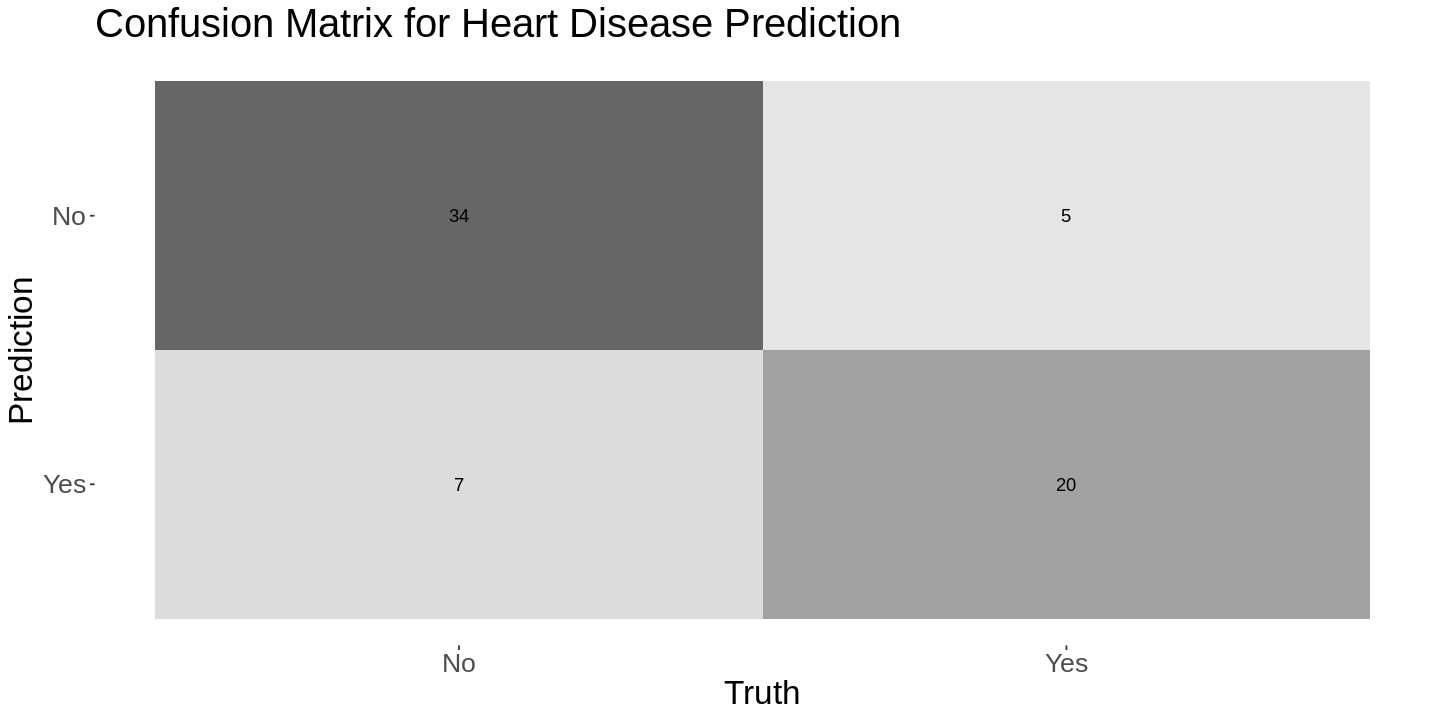

In [15]:
# Create confusion matrix
conf_matrix <- heart_test_predictions |>
             conf_mat(truth = has_heart_disease, estimate = .pred_class)

# Confusion matrix visualization
conf_matrix_plot <- autoplot(conf_matrix, type = "heatmap") +
   ggtitle("Confusion Matrix for Heart Disease Prediction") +
   theme(text = element_text(size = 20))
conf_matrix_plot

Figure 5: Confusion Matrix Plot for Heart Disease Prediction on Testing Set

# Discussion

In order to find which predictors strongly correlate with heart disease, we built a k-nn classification model with the processed hungarian dataset. 
Why we used KNN classification:
We used k-nn classification because we are trying to predict a categorical class (has heart disease or does not have heart disease) rather than a numerical/continuous value, in which case we would use regression.

As a result, our classifier has an 81.8% accuracy in predicting whether or not someone has heart disease, based on our predictors. This is a relatively good accuracy as we expected. Our data has an approximately 40% to 60% split between people that do have heart disease, and people that do not. This data is well-balanced enough to the point where we can rule out the possibility of a falsely high accuracy due to an imbalance of data. 
As a rule of thumb for KNN classification, we standardize our data because we do not want one variable to affect the classifier more than another. We would like them all to be weighted equally in the classifier to increase the likelihood of an accurate prediction.

#### Why we used our predictors
The reason we used the predictors that we did is because they all have some correlation with an individual having heart disease. 
- Age: As people grow older, the risk of heart disease rises exponentially. For this reason, age was one of our most important predictors of heart disease in an individual. This is also supported by Figures 2 and 3 during our exploratory data analysis which is explained in the next part of this report. 
- Max Heart Rate: Maximum heart rate is often correlated with heart disease in our dataset. When maximum heart rate was high, the individual was less likely to have heart disease and vice versa. This is also supported by Figures 2 and 4 during our exploratory data analysis which is explained in the next part of this report. 
- Sex: Generally, heart disease is more likely to affect men. After menopause, the risk of heart disease rises for women. This is why we used sex as a predictor. 
- Chest Pain Type: According to the heart disease data set website, they recorded 4 categories for chest pain. 1 is typical angina, 2 is atypical angina, 3 is non-anginal pain, 4 is asymptomatic. These categories can help predict heart disease as often people with heart disease will experience angina chest pain. Very low levels of fasting blood sugar is also considered a risk factor for heart disease, which is why we use that predictor.
- Resting Electrocardiographic Results: Angina is a type of chest pain caused by reduced blood flow to the heart, which is a very common symptom of coronary disease. ST depression refers to when the ST level on an electrocardiogram is low. This is often indicative of heart disease (Diderholm et al., 2002). 
- Cholesterol: As cholesterol levels rise the body develops fatty deposits in its blood vessels, these deposits accumulate over time and obstruct blood flow via the arteries, thereby greatly increasing the risk of heart disease. Therefore, cholesterol was an important predictor for heart disease. This is also supported by Figure 3 during our exploratory data analysis which is explained in the next part of this report. 
- Resting Blood Pressure: Studies suggest that if resting blood pressure is higher than a specified amount (120/80) then the individual is likely to be at risk of heart disease. Hence, this was a valued predictor in our analysis. This is also supported by Figure 4 during our exploratory data analysis which is explained in the next part of this report.


##### Figure 2: Max Heart Rate vs Age
From our visualization of the relationship between age and max heart rate in Figure 2, we can see that there is a weak negative relationship between the two variables. We also coloured the data points based on whether or not the person had heart disease. From there, we can see that older people with lower max heart rate tend to have heart disease, while younger people with higher max heart rate tend to not have heart disease. Interestingly, Older people with a high max heart rate tend not to have heart disease, while young people with a lower max heart rate lean slightly more towards having heart disease. This could have implications about people’s lifestyles, as people with healthier diets and who also exercise regularly are at less risk for heart disease.
##### Figure 3: Cholesterol vs Age
From this visualization of cholesterol vs age in Figure 3, we can observe that cholesterol levels are generally around the same across all ages. We can also infer that having slightly higher or slightly lower cholesterol levels does not really affect your risk for heart disease, as aside from the really extreme cases of having a standardized cholesterol level above 3, we can see that the amount of people who have heart disease and a standardized cholesterol above 0 is about roughly the same as those who have heart disease and a standardized cholesterol below 0. However, there is a more clear relationship between age and heart disease, as there is a much larger amount of people who have heart disease and a standardized age above 0 compared to those with a standardized age below 0. From this, we can suggest that age is perhaps a more helpful indicator of heart disease. This is likely due to the fact that as a person ages, their overall health deteriorates, which has a much larger impact than cholesterol levels.
There seems to be a relatively weak correlation between cholesterol and age. Instead there is a comparatively higher correlation between each predictor and whether the patient has heart disease. Generally, as age or cholesterol increases heart disease is more likely.
##### Figure 4:  Max Heart Rate vs Resting Blood Pressure
From this visualization of max heart rate and resting blood pressure in Figure 4, we can also see that having a higher maximum heart rate reduces risk of heart disease, as there is a considerably smaller amount of people with heart disease that have a standardized max heart rate above 0 compared to having a standardized max heart rate below 0.  Furthermore, there is also a higher ratio of people who have heart disease that also have high blood pressure, compared to those with a lower blood pressure. There are more patients with heart disease that have a standardized blood pressure above 0 then patients with a standardized blood pressure below 0. 

#### Explanation of Results
From the confusion matrix in Figure 5 we see that for our test set our classifier correctly predicted individuals that have heart disease 20 times and correctly predicted individuals that do not have heart disease 34 times. It incorrectly predicted individuals that have heart disease 5 times and incorrectly predicted individuals that do not have heart disease 7 times.

The total accuracy rate, which refers to all of the correct predictions divided by total number of predictions made was 20+3420+34+7+5100=5466100=81.8% which matches with the testing accuracy that R computed for us.
The total misclassification rate, which refers to the percentage of new observations that the model incorrectly predicted, for our model was 5+720+34+5+7100=1266100=18.2%.
The sensitivity, which refers to the “true positive” rate i.e. what percent of new positive observations (individuals who have heart disease) the model correctly predicted, for our model was 2020+7100=2027100=74.1%.
The specificity, which refers to the “true negative” rate i.e. what percent of new negative observations (individuals who don’t have heart disease) the model correctly predicted, for our model was 3434+5100=3439100=87.2%.

Based on these calculated values, we see that our model performed quite well. It has a fairly high accuracy, fairly low misclassification rate, and relatively high sensitivity and specificity. Our sensitivity value is lower than our specificity value which tells us that our model may be better at predicting negative values (individuals that do not have heart disease) than it did for positive values (individuals that do have heart disease). This may mean that our model is skewed toward better predicting negative values. If given more time and resources we would have liked to test on further data to determine whether our model was better at predicting on negative data and then make our model more robust by fixing this issue if necessary.


#### Suggestions for improvement
Our 81.8% accuracy is fairly good despite the relatively high number of predictors that we are using with our classifier since k-nn does not always work well with a high number of predictors. Moreover, there are known risk factors of heart disease such as family history or smoking that are not included in our data set. 
Smoking is probably one of the most dangerous risk factors of heart disease, as it also increases the chances of heart attack. (Wilhelmsen, 1988). Including this predictor in our dataset could have potentially helped improve our accuracy for our classifier.

Obesity is also another well-known risk factor of heart disease that was not mentioned in the dataset that we used. According to Freedman et al. (2001), obesity is strongly linked to morbidity of coronary heart disease, especially obesity from childhood. BMI was not mentioned in our dataset, and the inclusion of that may have helped increase the accuracy of our classifier. 
Stress is also an important risk factor for heart disease that was not recorded in the dataset. 
As Känel and Wirtz (2017) examine, Psychological stress is a risk factor for heart disease, as it increases inflammation. 
Classifiers such as this one can be useful in the field of medicine, as this idea can easily be extended to other health issues. Creating a classifier to help quickly predict the nature of someone’s illness can help the healthcare industry, which is being increasingly overwhelmed at this time of the year. 
There are many types of heart disease, ranging from angina, to heart attack to cardiac arrest and many more. To further extend our classifier, we could potentially try to predict what kind of heart disease a person may have based on our predictors, rather than trying to just determine if they have heart disease. We could use a different dataset in the future with predictors such as smoking, BMI or family history to increase the accuracy of the classifier. 
A limitation of our dataset is that the data is strictly recorded from patients in Hungary, which can limit the global influence our findings may have. This is because risk factors for heart failure tend to vary among different regions in the world. For example, in the high income west, there are more cases of heart failure from coronary heart disease, while in more developing regions, heart failure is more commonly associated with rheumatic heart disease and non-ischemic cardiomyopathies (Ezzati et al. ,2012). 

#### Significance of Findings

These findings could potentially show new relationships between factors that are known to be related to heart disease. This is impactful, because heart disease is a very common cause of death everywhere. It is important for data scientists in the healthcare industry to uncover as much information about heart disease.

A question this could lead to is whether or not our findings could be applied by heart doctors to help them predict heart disease more accurately.
Another question is whether or not certain predictors have more correlation to heart disease than others.